# Final Project: Proposal

## Title: Predicting Online Review Rating of Pizza Using Photos 

Ziv Branstein 301782215

Avishai Fuss 332658608

### Contents
* [Project Goals](#first-bullet)
* [Motivation](#second-bullet)
* [Data Exploration](#third-bullet)
* [Initial Results](#fifth-bullet)
* [Further work](#fourth-bullet)

### Project Goals <a class="anchor" id="first-bullet"></a>

Given a product class, we aim to determine whether a picture of a product from said class can be used to accurately predicate customer product ratings.
In order to reasonably fit the project in the given time constraints we've focused our project on the product class of pizza.



###  Motivation <a class="anchor" id="second-bullet"></a>

Online shopping has been on the rise for some time now around the world, while traditional brick-and-mortar businesses struggle to compete. For instance, in the US over the past ten years, e-commerce has grown at a rate ~4x faster than that of retail overall.

![alt text](https://github.com/shaifuss/data_science_seminar/blob/master/ecommercegrowth.jpg?raw=1)

This shifting landscape has brought vast changes to the customer experience and has impacted the way customers make purchasing decisions. Rather than browsing the aisles at a local store, consumers can survey a wide variety of options from several competitors at once. They're no longer limited to the inventory and shelf space of a physical store. 

Online reviews are the biggest game changer. The online experience offers consumers the chance to get neutral third-party feedback from others who have already tried the product. This is a superior alternative to getting advice from retail sales associates who are incentivized to push products. It's no wonder that, according to Northwestern University's Spiegel Research Center, [almost 95% of online shoppers consult reviews before making a purchase](https://spiegel.medill.northwestern.edu/_pdf/Spiegel_Online%20Review_eBook_Jun2017_FINAL.pdf). 

It comes as no surprise, then, that businesses tend to invest heavily in curating their online reputation in ways that have eroded consumer trust in online reviews. One such example is [brushing](https://en.wikipedia.org/wiki/Brushing_(e-commerce)), where business owners buy their own products in order to post reviews as "verified" purchasers. Less dubious methods are common as well. The Spiegel Center report highlights several innocuous factors that can be manipulated to influence consumer behavior. 

![alt text](https://github.com/shaifuss/data_science_seminar/blob/master/spiegel.jpg?raw=1)

What if we could just do away with the whole game of cat and mouse? In this project, we aim to test the hypothesis that product images alone are enough to glean information about customer reviews. If successful, this strategy has the potential to restore consumer trust in the world of online shopping. They say a picture is worth a thousand words...



### Data Exploration <a class="anchor" id="third-bullet"></a>

This hypothesis is obviously relevant only to certain sectors. Customers likely don't care what the insulation in their house looks like, as long as it gets the job done. We've chosen to test our hypothesis on relevent segments of the [Yelp dataset](https://www.yelp.com/dataset) - an extensive collection of reviews and ratings for businesses located in 11 metropolitan areas. 

In [0]:
import warnings
warnings.filterwarnings('ignore')

import json
import os
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns 
import pprint
from scipy.stats import binom
from sklearn.metrics import confusion_matrix

In [2]:
if not os.path.exists('review_photos'):
    if os.path.exists('data_science_seminar'):
        %cd data_science_seminar
    else:
        !git clone https://github.com/shaifuss/data_science_seminar.git
        %cd data_science_seminar
if (not os.path.exists('yelp_academic_dataset_business.json')) or (not os.path.exists('yelp_academic_dataset_review.json')):
    kaggle_path = os.path.expanduser('~/.kaggle')
    kaggle_json_path = os.path.join(kaggle_path, 'kaggle.json')
    if not os.path.exists(kaggle_json_path):
        from getpass import getpass
        kaggle_json = getpass('Insert kaggle.json:')
        os.makedirs(kaggle_path, exist_ok=True)
        with open(kaggle_json_path, 'w') as f:
            f.write(kaggle_json)
        os.chmod(kaggle_json_path, 0o600)
    !kaggle datasets download yelp-dataset/yelp-dataset
    !unzip yelp-dataset.zip yelp_academic_dataset_business.json yelp_academic_dataset_review.json
    !rm yelp-dataset.zip

/content/data_science_seminar


In [3]:
business_df = pd.read_json('yelp_academic_dataset_business.json', lines=True)
print("The dataset contains a total of {} businesses".format(len(business_df.index)))

The dataset contains a total of 209393 businesses


In [4]:
business_df = business_df[business_df['categories'].notna()]
pizza_biz_df = business_df[business_df['categories'].str.contains("Pizza")]
print("Of those, {} businesses sell pizza".format(len(pizza_biz_df.index)))
print("Here are a few examples")
pizza_biz_df.head()

Of those, 7302 businesses sell pizza
Here are a few examples


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
63,ZkzutF0P_u0C0yTulwaHkA,Lelulos Pizzeria,311 Unity Center Rd,Plum,PA,15239,40.489996,-79.779288,4.0,31,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Restaurants, Pizza","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."
86,OWkS1FXNJbozn-qPg3LWxg,Mama Napoli Pizza,,Las Vegas,NV,89109,36.128561,-115.171130,4.5,11,1,"{'RestaurantsDelivery': 'False', 'BusinessAcce...","Food, Food Trucks, Restaurants, Pizza",{'Friday': '18:0-0:0'}
105,-C0AlwLuXpcP609madJZQQ,Pizzaville,"1030 Kennedy Circle, Unit 10",Milton,ON,L9T 0J9,43.508962,-79.837990,3.5,7,1,None,"Restaurants, Pizza","{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ..."
120,39lLJK_rrYY2NYomSsQdUA,Marco's Pizza,24335 Chagrin Blvd,Beachwood,OH,44122,41.465789,-81.506349,2.5,11,1,"{'RestaurantsDelivery': 'True', 'GoodForKids':...","Restaurants, Pizza",None
126,0y6alZmSLnPzmG5_kP5Quw,J J's Pizza,20542 Lorain Rd,Fairview Park,OH,44126,41.448341,-81.847644,4.5,21,1,"{'NoiseLevel': 'u'quiet'', 'WiFi': ''no'', 'Bu...","Pizza, Italian, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."


In [5]:
pizza_business_ids = set(pizza_biz_df.business_id)
pizza_reviews = []
with open('yelp_academic_dataset_review.json', 'r') as f:
    for line in f:
        line_json = json.loads(line)
        if line_json['business_id'] in pizza_business_ids:
            pizza_reviews.append(line_json)
print(f"And a total of {len(pizza_reviews)} reviews")

And a total of 479792 reviews


Summary and distribution statistics of pizzaria ratings

In [6]:
pizza_df = pd.DataFrame(pizza_reviews)
pizza_df = pizza_df.set_index("review_id")
pizza_df.describe()

,stars,useful,funny,cool
count,479792.000000,479792.000000,479792.000000,479792.000000
mean,3.708130,1.059109,0.453807,0.513481
std,1.448307,4.439882,4.160658,2.409803
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000
max,5.000000,1122.000000,976.000000,502.000000


In [0]:
def pizza_plot(x, title, ylabel, xlabel, size):
  x=x.sort_index()
  plt.figure(figsize=size)
  ax= sns.barplot(x.index, x.values, alpha=0.8)
  plt.title(title)
  plt.ylabel(ylabel, fontsize=12)
  plt.xlabel(xlabel, fontsize=12)

  rects = ax.patches
  labels = x.values
  for rect, label in zip(rects, labels):
      height = rect.get_height()
      ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

  plt.show()

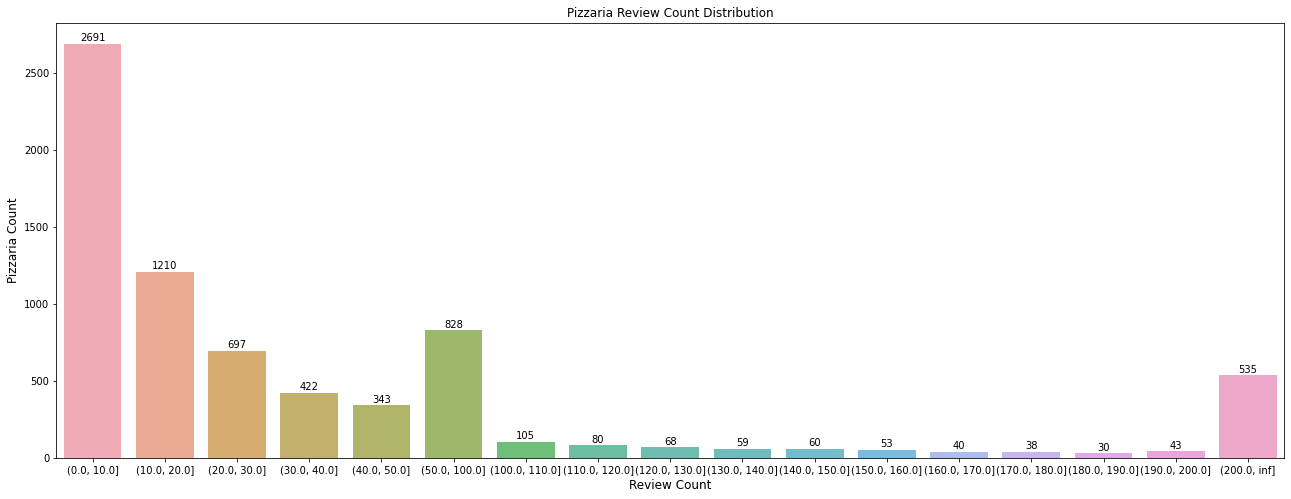

In [8]:
out = pd.cut(pizza_biz_df['review_count'], bins=[0, 10, 20, 30, 40, 50, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, float("inf")])
pizza_plot(out.value_counts(), "Pizzaria Review Count Distribution", 'Pizzaria Count', 'Review Count', (22, 8))

About a third of pizzerias have between 0-10 reviews, which might cast doubt as to whether those reviews are representative.

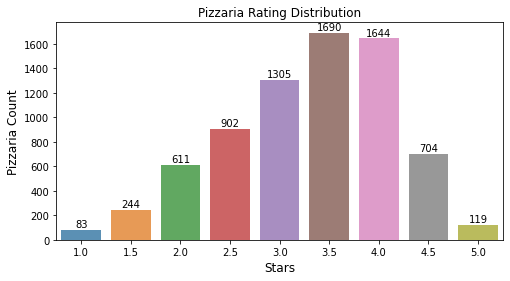

In [9]:
pizza_plot(pizza_biz_df['stars'].value_counts(), "Pizzaria Rating Distribution", 'Pizzaria Count', 'Stars', (8,4))

The overall rating distribution is generally normal with a slight negative skew.

Online reviewers are a self selecting group. It takes some time and effort to write out a review and upload pictures. Intuitively, customer who feel passionate about their experience should be more likely to upload a review. For this reason, it's typical to see an extreme distribution where ratings are bunched really high and really low but not in the middle. Let's look at the score distribution for an example pizzaria. First we gather the reviews.

We combined yelp's dataset with the reviews' images by scraping their website. After scraping 2,500~ photos of reviews, many of them were photos of unrelated dishes, menus or even people. 

An implementation of the [Xception architecture](http://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf) was used to retain only images of pizza. Xception is a variation on the Inception convolusional neural network (CNN) architecture. 

Beyond the standard CNN features, the essential modification introduced with Inception is multiple filter sizes within the same layer. One reason this is useful is to account for varied object sizes within the frame. However, the larger filters incur significant computational costs that result from all the multiplication operations required. To mitigate this, a few performance optimizers were also introduced with Inception, such as filter factorization and banking. 

Xception further improves performance by utilizing a divide and conquer strategy called depthwise seperable convolusion. First, instead of running convolution on the entire input, a seperate filter is used for each input channels (i.e. layer of the input tensor). Next, pointwise convolution is performed to combine the filters (One might say that this technique is similar to multi-threading for processors). 

At this stage, 950~ photos of (mostly) pizza remain.

In [10]:
pic_path = 'review_photos'
pix_review_ids = [f for f in os.listdir(pic_path) if os.path.isdir(os.path.join(pic_path, f))]

pizza_business_with_pix_ids = []
for review in pizza_reviews:
  if review['review_id'] in pix_review_ids: 
    pizza_business_with_pix_ids.append(review['business_id'])
pizza_business_with_pix_ids = set(pizza_business_with_pix_ids)

pizza_biz_pix_df = pizza_biz_df[pizza_biz_df['business_id'].isin(pizza_business_with_pix_ids)]
sort_za = pizza_biz_pix_df.sort_values(by=['review_count'], ascending=False)
example_id = sort_za['business_id'].iloc[0]
print("This is the rating distribution for pizzaria id: {}".format(example_id)) 

This is the rating distribution for pizzaria id: 0FUtlsQrJI7LhqDPxLumEw


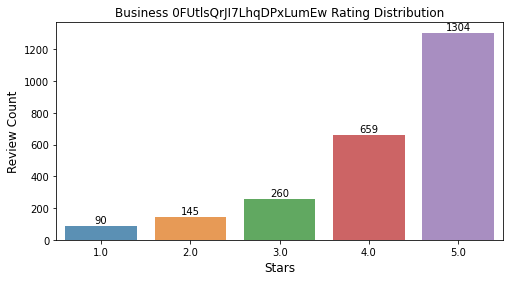

In [11]:
# gather reviews
review_df = pd.DataFrame.from_records(pizza_reviews)
pic_review_df = review_df[review_df['business_id'] == example_id]
pizza_plot(pic_review_df['stars'].value_counts(), "Business {} Rating Distribution".format(example_id), 'Review Count', 'Stars', (8,4))

This pizza restaurant with the highest number of reviews has a left long-tail distribution. It contains only one half of the extreme distribution. Maybe that's why they have so many customers. It also means we'll have to deal with uneven data when training out model. 



#### Here are a couple examples of 1 star reviews and their respective review:

Review: I like sauce, but I'm going to give them 1 star for thinking it's ok to burn a pizza, box it up and not mention it to me when I came in to pick it up. I'm now home and practically snapping my teeth when I take a bite. I'm too tired to take it back and demand they make another. Poor decision on their part to pull this crap.


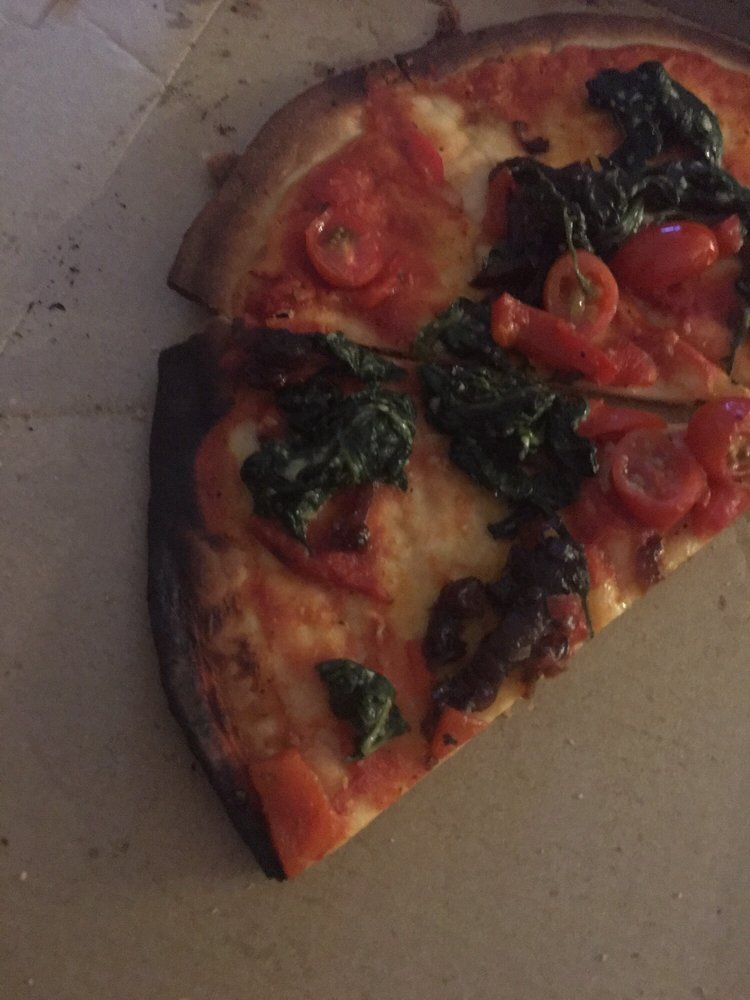

In [12]:
print(f'Review: {pizza_df.loc["cpt9ySBm6p8QjyUioLChUw", "text"]}')
Image(filename=os.path.join("review_photos", "cpt9ySBm6p8QjyUioLChUw", "0.jpg"), width=300, height=300)

Review: Obvious this restaurant is not familiar with GOOD GREAT coal fire pizza.
This had to be one of the worst pizza, if that's what you want to call it, I have had.
It was a pita bread texture with minimal about of tomatoes.  I mean minimal.
Cheese harden quickly and I didn't see one piece of basil.
Being 100% Italian I had to share my thoughts about this terrible experience.
 On a positive note, the salad was good.


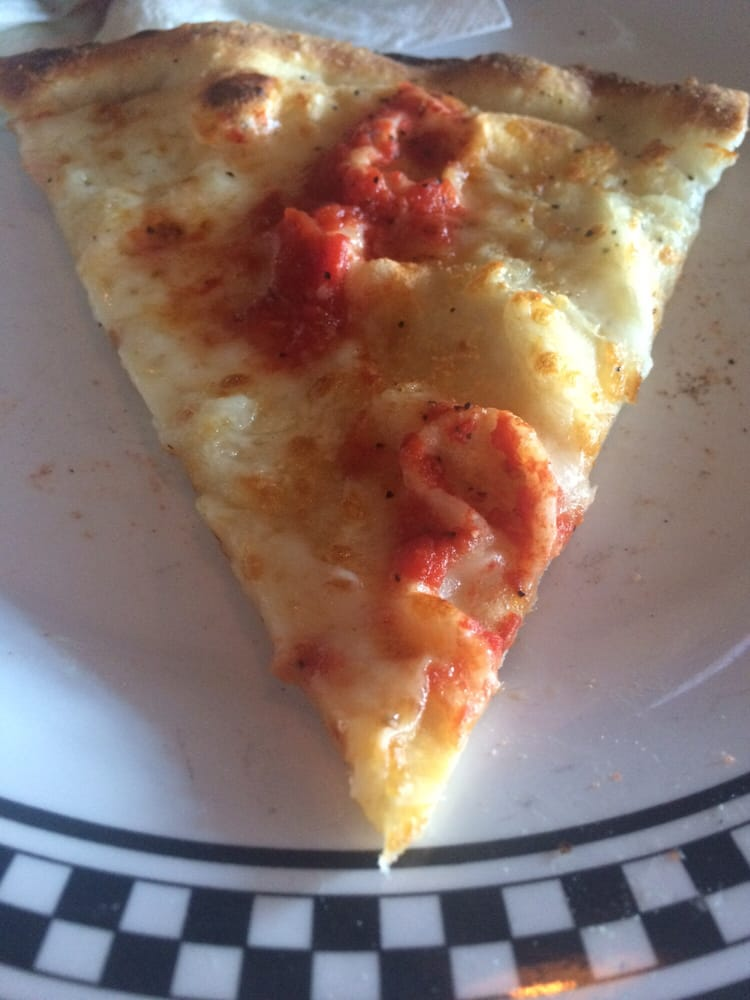

In [13]:
print(f'Review: {pizza_df.loc["-snGZCUWiW_Lyp3kKtObFA", "text"]}')
Image(filename=os.path.join("review_photos", "-snGZCUWiW_Lyp3kKtObFA", "0.jpg"), width=300, height=300)

#### And here are a couple examples of 5 star reviews and their respective review:

Review: Delicious huge slices for reasonable prices. They bring the pizza to your table and they also have wifi.


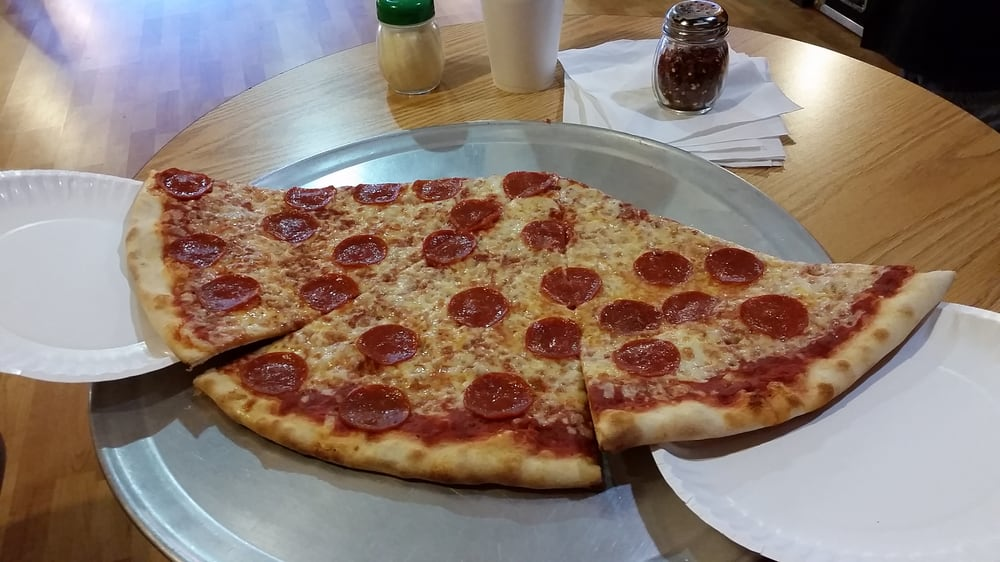

In [14]:
print(f'Review: {pizza_df.loc["n6l8Q8SzHiz60NPOsUVAcQ", "text"]}')
Image(filename=os.path.join("review_photos", "n6l8Q8SzHiz60NPOsUVAcQ", "0.jpg"), width=300, height=300)

Review: Tried Pizza Fire for the first time tonight and loved it! Purchased two pizzas to go and chose a variety of toppings. All very yummy! My niece tried the margherita and devoured it. Our family will definitely return again and again! It's great to have local pizza that doesn't taste greasy or overly processed like most chains do. Crust has a great texture and the flavors are exactly what you'd want from a fresh pizza. Worth the visit!


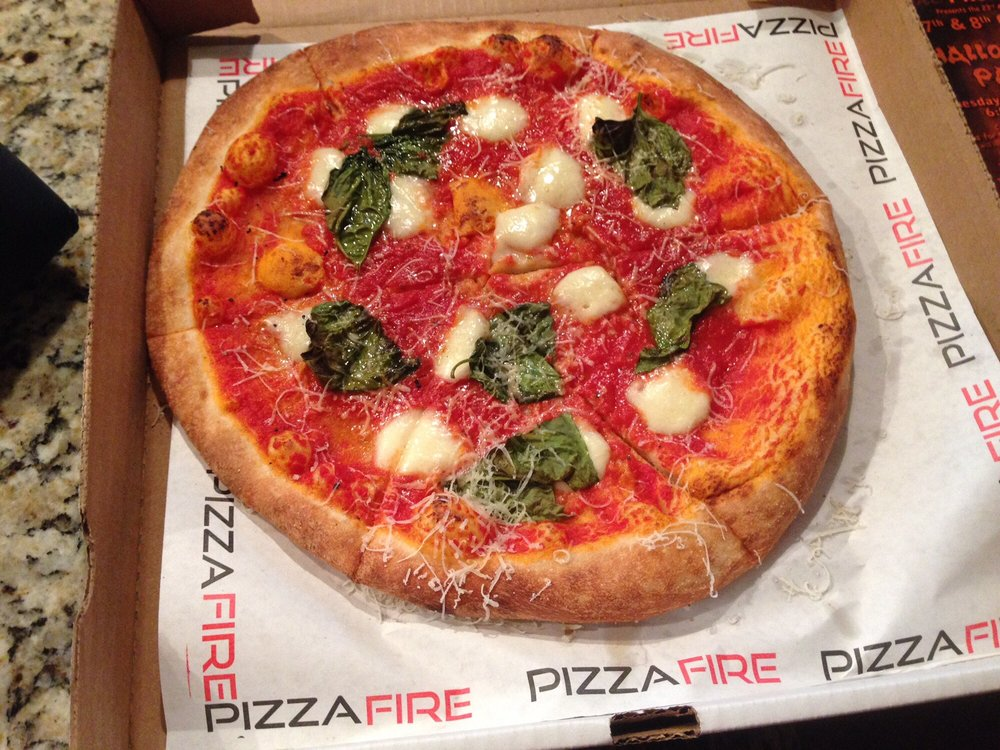

In [15]:
print(f'Review: {pizza_df.loc["yRyd_0zqdM6ZepbX24K0qg", "text"]}')
Image(filename=os.path.join("review_photos", "yRyd_0zqdM6ZepbX24K0qg", "0.jpg"), width=300, height=300)

### Initial Results <a class="anchor" id="fifth-bullet"></a>

In [0]:
from collections import defaultdict
import numpy as np
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [0]:
review_ids_with_photos = list(os.listdir("review_photos"))
pizza_reviews_by_id = {pizza_review["review_id"]: pizza_review for pizza_review in pizza_reviews}
stars_to_photos = defaultdict(lambda: [])
for review_id_with_photos in review_ids_with_photos:
    review_path = os.path.join("review_photos", review_id_with_photos)
    for filename in os.listdir(review_path):
        img_path = os.path.join(review_path, filename)
        img = image.load_img(img_path, target_size=(299, 299))
        img_array = image.img_to_array(img)
        x = np.expand_dims(img_array, axis=0)
        x = preprocess_input(x)

        stars_to_photos[pizza_reviews_by_id[review_id_with_photos]["stars"]].append(x)

In [18]:
{star_count: len(stars_to_photos[star_count]) for star_count in stars_to_photos}

{1.0: 263, 2.0: 22, 3.0: 88, 4.0: 275, 5.0: 310}

Unfortunately many of the 1 and 2 star reviews do not contain a photo, which skewes the dataset. In the proposal we decided to cluster 1+2 star reviews against 5 star reviews and limit the number of 5 star reviews to match those of 1+2 stars. We note that the extreme distribution is a hallmark of online reviews, making this an appropriate choice, as discussed [here](http://www.columbia.edu/~on2110/Papers/Schoenmueller_netzer_stahl_2018.pdf). 

We also treat the problem as a classification problem(i.e. either 1 star or 5 stars) instead of a regression(i.e. the number of stars) to make the model simpler.


In [19]:
X = np.concatenate([np.concatenate(stars_to_photos[i]) for i in [1, 2]])
X = np.concatenate([X] + stars_to_photos[5][:X.shape[0]])
y = np.repeat(0.0, len(stars_to_photos[1]) + len(stars_to_photos[2]))
y = np.concatenate([y, np.repeat(1.0, len(stars_to_photos[1]) + len(stars_to_photos[2]))]).reshape(-1, 1)
X.shape, y.shape

((570, 299, 299, 3), (570, 1))

In [20]:
# Split data into train, validation and test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_trainval, y_trainval, test_size=0.3, stratify=y_trainval, random_state=42)
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((279, 299, 299, 3),
 (279, 1),
 (120, 299, 299, 3),
 (120, 1),
 (171, 299, 299, 3),
 (171, 1))

We use Xception as a pretrained model to do feature extraction, on top of which train our model.

In [0]:
# create the base pre-trained model
base_model = Xception(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(8, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Do not change the pretrained model
base_model.trainable = False

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=["accuracy"])

We train the model using the existing examples and perform data augmentation to improve the training.

In [22]:
train_generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
train_generator.fit(X_train)
validation_generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
validation_generator.fit(X_validation)
patience = 15
h = model.fit(
    train_generator.flow(X_train, y_train, batch_size=32), 
    steps_per_epoch=X_train.shape[0] // 32, 
    validation_data=validation_generator.flow(X_validation, y_validation, batch_size=32), 
    validation_steps = X_validation.shape[0] // 32,
    epochs=10000, 
    callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)],
    verbose=0
)
print(f"Best epoch: loss: {h.history['loss'][-patience - 1]}, accuracy: {h.history['accuracy'][-patience - 1]}, val_loss: {h.history['val_loss'][-patience - 1]}, val_accuracy: {h.history['val_accuracy'][-patience - 1]}")

Best epoch: loss: 0.4468249976634979, accuracy: 0.8218623399734497, val_loss: 0.5603277683258057, val_accuracy: 0.6770833134651184


In [23]:
_, test_accuracy = model.evaluate(X_test, y_test)

6/6 [==============================] - 1s 128ms/step - loss: 0.5901 - accuracy: 0.6901


In [24]:
class_ratio = np.sum(y_test) / y_test.shape[0]
max_random_probablity = max(class_ratio, 1 - class_ratio)
p_better_than_random = 1 - binom.cdf(round(y_test.shape[0] * test_accuracy), n=y_test.shape[0], p=max_random_probablity)
print(f"The probability of a random classifier to outperform these results on the test set is: {p_better_than_random}")

The probability of a random classifier to outperform these results on the test set is: 2.3858538589216494e-07


In [0]:
y_test_predicted = model.predict(X_test) > 0.5

In [0]:
examples_of_true_1_star = X_test[np.where((y_test_predicted == y_test) & (y_test == 0))[0][:2]]
examples_of_true_5_star = X_test[np.where((y_test_predicted == y_test) & (y_test == 1))[0][:2]]
examples_of_false_1_star = X_test[np.where((y_test_predicted != y_test) & (y_test == 1))[0][:2]]
examples_of_false_5_star = X_test[np.where((y_test_predicted != y_test) & (y_test == 0))[0][:2]]

Here are a few examples of successful and failed 1/5 stars classification:



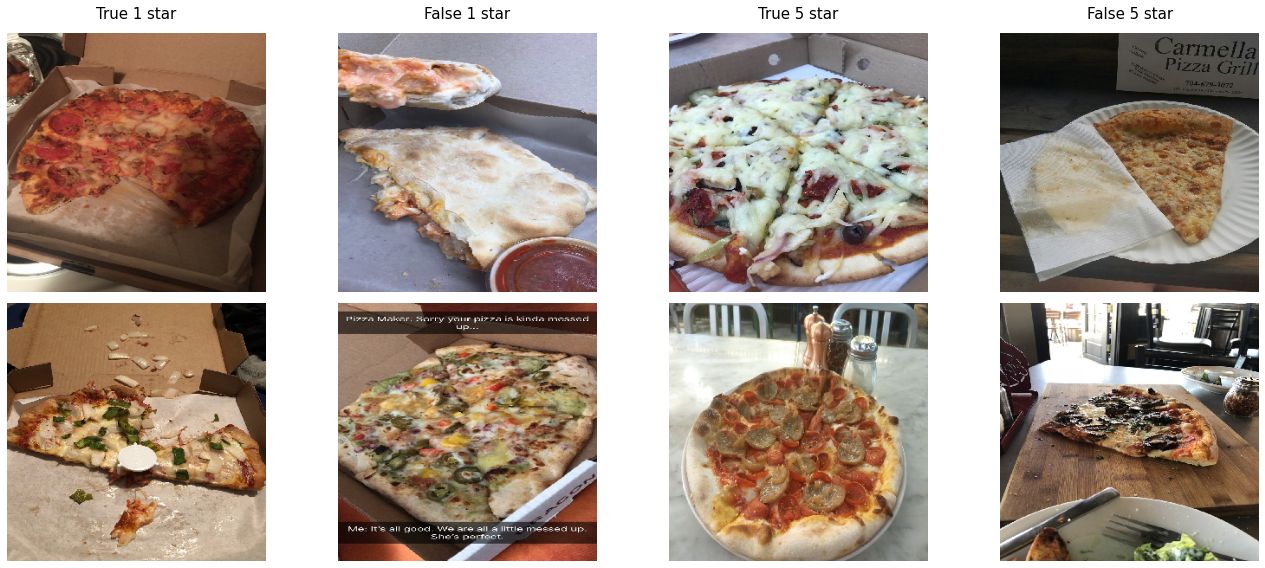

In [27]:
def plot_image(image_data, subplot):
  subplot.imshow((image_data + 1) / 2)
  subplot.axis('off')

print("Here are a few examples of successful and failed 1/5 stars classification:\n")
fig, axeslist = plt.subplots(ncols=4, nrows=2, figsize=(19, 8))
axeslist[0][0].set_title('True 1 star', fontsize=15, pad=15)
axeslist[0][1].set_title('False 1 star', fontsize=15, pad=15)
axeslist[0][2].set_title('True 5 star', fontsize=15, pad=15)
axeslist[0][3].set_title('False 5 star', fontsize=15, pad=15)

plot_image(examples_of_true_1_star[0], axeslist[0][0])
plot_image(examples_of_true_1_star[1], axeslist[1][0])

plot_image(examples_of_false_1_star[0], axeslist[0][1])
plot_image(examples_of_false_1_star[1], axeslist[1][1])

plot_image(examples_of_true_5_star[0], axeslist[0][2])
plot_image(examples_of_true_5_star[1], axeslist[1][2])

plot_image(examples_of_false_5_star[0], axeslist[0][3])
plot_image(examples_of_false_5_star[1], axeslist[1][3])

plt.tight_layout()

Here is a confusion matrix of the test set classification:

In [28]:
pd.DataFrame(confusion_matrix(y_test, y_test_predicted), index=['True: 1 star', 'True: 5 stars'], columns=['Predicted: 1 star', 'Predicted: 5 stars'])

,Predicted: 1 star,Predicted: 5 stars
True: 1 star,58,28
True: 5 stars,25,60


### Further work <a class="anchor" id="fourth-bullet"></a>

As demonstrated by the initial results above we are able to achieve statistically significant results over randomly guessing the current class.
However, there's probably room for improvement. We will attempt to design a more robust model, using the following strategies: 

#### Improved Image Classification

1) Experimenting with different pretrained classifiers for better feature extraction.

2) Experimenting with different classifier on the extracted features, for example trying different neural network architectures, or using Support Vector Machine instead of a neural network. 

3) Fine-tuning the pretrained model after initial training.

All of these improvements will probably benefit from more data. We'll try to expand the dataset through further scraping.

#### NLP-based Filtering
Use NLP tools during the preprocessing stage to filter out reviews in which the dishes are not the main reason for the score. Some filtering conditions include:

1) Retain only reviews where the text discusses on the food. 

2) Remove any reviews where the text expresses strong opinions about other aspects of the customer experience not relevent to food (i.e. "the service was really slow", "the waiter was very rude to us", etc).


#### Extras
Here are some other ideas that we think may futher improve our model, however we're not sure whether they will fit the scope of this project. If time allows we hope to get to test the following:

1) Improving the model to predict a continuous value(i.e. the number of stars) instead of a binary classification.

2) Many reviews contain multiple images. Essentially, all of these images are tied to the same class label. Classification may improve if they all could be treated as one example. [Multiple instance learning](https://en.wikipedia.org/wiki/Multiple_instance_learning) is a strategy that trains a classifier to predict labels from a group of items.

2) Adding a visual attention mechinism to the image classifier. Attention has gained a lot of momentum in the NLP domain, and is being explored in computer vision as well. As we learned in the presentation we did on adversarial attacks on computer vision systems, image classification can be very fragile. Explicitly training the network to focus on the subject rather than the background with attention could improve results.